It is possible to run the part where the data is obtained from the torch_geometric repository, but not the one regarding the data from the first assignment as it is uploaded in a private folder. If needed, ask.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/'Colab Notebooks'/SDM

/content/drive/MyDrive/Colab Notebooks/SDM


In [ ]:
!pip install sentence-transformers -q
!pip install torch_geometric -q
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.0.0+cu118.html -q

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from sentence_transformers import SentenceTransformer
from sklearn.cluster import SpectralClustering
from sklearn.metrics import classification_report

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear
from torch_geometric.datasets import DBLP
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import HeteroData

2.0.1+cu118
cpu


In [ ]:
dataset = DBLP(root='./data', transform=T.ToUndirected())
data = dataset[0]

data.to(device)

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=32,
    input_nodes=('author', data['author'].train_mask),
)

val_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    input_nodes=('author', data['author'].val_mask),
)

def train():
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch['author'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out[:batch_size],
                               batch['author'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

@torch.no_grad()
def evaluate():
    model.eval()

    data = val_loader.data
    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    val_mask = data['author'].val_mask  # Get the validation mask
    correct = (preds[val_mask] == data['author'].y[val_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(val_mask.sum())  # Calculate accuracy.

    return accuracy, preds[val_mask]

@torch.no_grad()
def test():
    model.eval()

    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    test_mask = data['author'].test_mask  # Get the validation mask
    correct = (preds[test_mask] == data['author'].y[test_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(test_mask.sum())  # Calculate accuracy.

    return accuracy, preds[test_mask]

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('paper', 'to', 'term'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('author', 'to', 'paper'): SAGEConv((-1, -1), hidden_channels),
                ('paper', 'rev_to', 'author'): SAGEConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

model = HeteroGNN(hidden_channels=64, out_channels=4, num_layers=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.no_grad():  # Initialize lazy modules.
     _ = model(data.x_dict, data.edge_index_dict)

In [ ]:
train_losses = []
eval_accs = []
epochs = range(1)
for epoch in epochs:
    train_loss = train()
    train_losses.append(train_loss)
    # eval_acc, _ = evaluate()
    # eval_accs.append(eval_acc)
    # print(epoch, train_loss, eval_acc)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
print(classification_report(data['author'].y[data['author'].test_mask].cpu().numpy(), predictions.cpu().numpy()))

NameError: ignored

### Load Custom Data

In [ ]:
data = pd.read_csv('data/papers.csv')

In [ ]:
data.head()

,id,pages,title,author_ids,volume_id,edition_id,abstract,doi,keyword_ids
0,0,49-61,Estimating Traffic Disruption Patterns with Vo...,2685|70|3102|76|1426,13.0,NaN,"In this paper, we present an approach to devel...",jvlywkquewps,43|16|17|2|25
1,1,28-34,A Speaker-aware Parallel Hierarchical Attentiv...,1326|1181|136|1158,4.0,NaN,"In this paper, we present an empirical analysi...",ffthtdqohkxj,29|33|28|26|43
2,2,26-43,Robust Dialog State Tracking for Large Ontolog...,228|501|230|503|1692,93.0,NaN,"In this paper, we present an approach to devel...",yfwkbkvjolvv,30|10|11|5|9
3,3,23-30,From compression to compressed sensing,1716|628,98.0,NaN,"In this paper, we show that a simple system th...",lomhkwmufiws,3|17|21|2|10
4,4,10668-10688,Using Class Probabilities to Map Gradual Trans...,1155|1967|1866|1917|1859|1159,54.0,NaN,"In this paper, we propose three proposed hypot...",geohcjlqsdai,35|44|14|5|39


In [ ]:
data.shape

(998, 9)

In [ ]:
data.iloc[0].loc['title']

'Estimating Traffic Disruption Patterns with Volunteered Geographic Information.'

### Load encoder and get title embeddings

In [ ]:
ft_model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
with torch.no_grad():
    article_features = data['title'].map(ft_model.encode)

In [ ]:
X = article_features.apply(pd.Series)

### Get clusters

In [ ]:
clustering = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit_predict(X)
data['cluster'] = clustering

In [ ]:
unique_values, counts = np.unique(clustering, return_counts=True)

# Zip the unique values and counts together
value_counts = dict(zip(unique_values, counts))

# Print the value counts
for value, count in value_counts.items():
    print(f"{value}: {count}")

0: 187
1: 319
2: 278
3: 214


Assign group to author by paper majority class

In [ ]:
# # Assuming df is your DataFrame and it has columns 'article_cluster' and 'authors'
# # Split authors into list
# data['author_ids'] = data['author_ids'].str.split('|')

# # Explode the DataFrame on the 'authors' column so there is one row per author per article
# df_exploded = data.explode('author_ids')

# # Find the majority class of 'article_cluster' for each author
# majority_class = df_exploded.groupby('author_ids')['cluster'].agg(lambda x: x.value_counts().index[0])

# print(majority_class)

Transform into HeteroData object

In [ ]:
# Mapping from id to integer
author_mapping = {}
paper_mapping = {}

# Integer format for ids
author_counter = 0
paper_counter = 0

author_paper_edges = []

for i, row in data.iterrows():
    paper_id = row['id']
    author_ids = row['author_ids'].split('|')

    # Map the paper id to an integer if it hasn't been done yet
    if paper_id not in paper_mapping:
        paper_mapping[paper_id] = paper_counter
        paper_counter += 1

    # Convert paper id to integer format
    paper_id_int = paper_mapping[paper_id]

    for author_id in author_ids:
        # Map the author id to an integer if it hasn't been done yet
        if author_id not in author_mapping:
            author_mapping[author_id] = author_counter
            author_counter += 1

        # Convert author id to integer format
        author_id_int = author_mapping[author_id]

        # Add edge
        author_paper_edges.append((author_id_int, paper_id_int))

# Convert to tensor
author_paper_edge_index = torch.tensor(author_paper_edges, dtype=torch.long).t().contiguous()

In [ ]:
# Prepare your nodes and edge index
author_nodes = torch.zeros((len(author_mapping),), dtype=torch.float)  # Empty tensor for author nodes
article_nodes = torch.tensor(article_features, dtype=torch.float)  # Tensor of article features (encoded titles)

# Create HeteroData object
data = HeteroData()

# Add nodes
data['author'].x = author_nodes[:, None]
data['paper'].x = article_nodes

# Add edge indices
data['author', 'writes', 'paper'].edge_index = author_paper_edge_index

# Add class labels if they exist
data['paper'].y = torch.tensor(clustering)  # Tensor of author class labels

<ipython-input-16-a3c83aa3cdab>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  article_nodes = torch.tensor(article_features, dtype=torch.float)  # Tensor of article features (encoded titles)


In [ ]:
data

HeteroData(
  author={ x=[3736, 1] },
  paper={
    x=[998, 768],
    y=[998]
  },
  (author, writes, paper)={ edge_index=[2, 4357] }
)

Split

In [ ]:
n_papers = len(article_nodes)

# Create boolean arrays for masking
train_mask = np.zeros(n_papers, dtype=bool)
val_mask = np.zeros(n_papers, dtype=bool)

# Define your splits - for example 80% train, 20% validation
train_prop = 0.8
val_prop = 0.2

# Create an array of indices and shuffle it
indices = np.arange(n_papers)
np.random.shuffle(indices)

# Define the splitting indices
train_split = int(train_prop * n_papers)
val_split = int(val_prop * n_papers) + train_split  # We add the train_split to move the index forward

# Assign the masks
train_mask[indices[:train_split]] = True
val_mask[indices[train_split:]] = True

# Convert to PyTorch tensors
train_mask = torch.from_numpy(train_mask)
val_mask = torch.from_numpy(val_mask)

# Add masks to your HeteroData object
data['paper'].train_mask = train_mask
data['paper'].val_mask = val_mask

In [ ]:
data

HeteroData(
  author={ x=[3736, 1] },
  paper={
    x=[998, 768],
    y=[998],
    train_mask=[998],
    val_mask=[998]
  },
  (author, writes, paper)={ edge_index=[2, 4357] }
)

In [ ]:
data['paper', 'written_by', 'author'].edge_index = torch.flip(data.edge_index_dict[('author', 'writes', 'paper')], [0])

In [ ]:
data

HeteroData(
  author={ x=[3736, 1] },
  paper={
    x=[998, 768],
    y=[998],
    train_mask=[998],
    val_mask=[998]
  },
  (author, writes, paper)={ edge_index=[2, 4357] },
  (paper, written_by, author)={ edge_index=[2, 4357] }
)

Define model to train:

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('author', 'writes', 'paper'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('paper', 'written_by', 'author'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['paper'])

model = HeteroGNN(hidden_channels=64, out_channels=4,
                  num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model.to('cpu')
with torch.no_grad():  # Initialize lazy modules.
     out = model(data.x_dict, data.edge_index_dict)

In [ ]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[20] * 2,
    batch_size=32,
    input_nodes=('paper', data['paper'].train_mask),
)

In [ ]:
for batch in train_loader:
    break

In [ ]:
out.shape

torch.Size([998, 4])

In [ ]:
model.to(device)
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch['paper'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out[:batch_size],
                               batch['paper'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

train()

100%|██████████| 25/25 [00:00<00:00, 76.92it/s]


0.712508470716333

In [ ]:
data.to(device)
@torch.no_grad()
def evaluate():
    model.eval()

    with torch.no_grad():
        output = model(data.x_dict, data.edge_index_dict)
        predictions = output.argmax(dim=1)  # Get the class with the highest probability.
        correct = (predictions == data['paper'].y)  # Compare with ground-truth labels.
        accuracy = int(correct.sum()) / int(data['paper'].y.size(0))  # Calculate accuracy.

    return accuracy, predictions

accuracy, predictions = evaluate()
print(f'Accuracy: {accuracy}')

# If your data has ground truth labels, you can also use sklearn's classification_report for a detailed report.
print(classification_report(data['paper'].y.cpu().numpy(), predictions.cpu().numpy()))

Accuracy: 0.9208416833667334
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       187
           1       0.97      0.92      0.94       319
           2       0.99      0.89      0.94       278
           3       0.81      0.90      0.86       214

    accuracy                           0.92       998
   macro avg       0.92      0.93      0.92       998
weighted avg       0.93      0.92      0.92       998



## DBLP from PyG

In [ ]:
dataset = DBLP(root='./data', transform=T.ToUndirected())
data = dataset[0]

In [ ]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={ num_nodes=20 },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] },
  (paper, rev_to, author)={ edge_index=[2, 19645] },
  (author, rev_to, paper)={ edge_index=[2, 19645] },
  (term, rev_to, paper)={ edge_index=[2, 85810] },
  (conference, rev_to, paper)={ edge_index=[2, 14328] },
  (paper, rev_to, term)={ edge_index=[2, 85810] },
  (paper, rev_to, conference)={ edge_index=[2, 14328] }
)

In [ ]:
dataset = DBLP(root='./data', transform=T.ToUndirected())
data = dataset[0]

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('paper', 'to', 'term'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('author', 'to', 'paper'): SAGEConv((-1, -1), hidden_channels),
                ('paper', 'rev_to', 'author'): SAGEConv((-1, -1), hidden_channels),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

model = HeteroGNN(hidden_channels=128, out_channels=4,
                  num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.to(device)
with torch.no_grad():  # Initialize lazy modules.
     out = model(data.x_dict, data.edge_index_dict)

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=32,
    input_nodes=('author', data['author'].train_mask),
)

val_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    input_nodes=('author', data['author'].val_mask),
)

def train():
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch['author'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out[:batch_size],
                               batch['author'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

@torch.no_grad()
def evaluate():
    model.eval()

    data = val_loader.data
    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    val_mask = data['author'].val_mask  # Get the validation mask
    correct = (preds[val_mask] == data['author'].y[val_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(val_mask.sum())  # Calculate accuracy.

    return accuracy, preds[val_mask]

@torch.no_grad()
def test():
    model.eval()

    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    test_mask = data['author'].test_mask  # Get the validation mask
    correct = (preds[test_mask] == data['author'].y[test_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(test_mask.sum())  # Calculate accuracy.

    return accuracy, preds[test_mask]

model.to(device)
data.to(device)

train_losses = []
eval_accs = []
epochs = range(10)
for epoch in epochs:
    train_loss = train()
    train_losses.append(train_loss)
    eval_acc, _ = evaluate()
    eval_accs.append(eval_acc)
    print(epoch, train_loss, eval_acc)

print(classification_report(data['author'].y[data['author'].test_mask].cpu().numpy(), predictions.cpu().numpy()))

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
model.to('cpu')
with torch.no_grad():  # Initialize lazy modules.
     out = model(data.x_dict, data.edge_index_dict)

In [ ]:
train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=32,
    input_nodes=('author', data['author'].train_mask),
)

In [ ]:
val_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[15] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    input_nodes=('author', data['author'].val_mask),
)

In [ ]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = batch['author'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out[:batch_size],
                               batch['author'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

@torch.no_grad()
def evaluate():
    model.eval()

    data = val_loader.data
    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    val_mask = data['author'].val_mask  # Get the validation mask
    correct = (preds[val_mask] == data['author'].y[val_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(val_mask.sum())  # Calculate accuracy.

    return accuracy, preds[val_mask]

@torch.no_grad()
def test():
    model.eval()

    out = model(data.x_dict, data.edge_index_dict)
    preds = out.argmax(dim=1)  # Get the class with the highest probability.

    test_mask = data['author'].test_mask  # Get the validation mask
    correct = (preds[test_mask] == data['author'].y[test_mask])  # Compare with ground-truth labels in the validation set.
    accuracy = int(correct.sum()) / int(test_mask.sum())  # Calculate accuracy.

    return accuracy, preds[test_mask]

In [ ]:
model.to(device)
data.to(device)

train_losses = []
eval_accs = []
epochs = range(1)
for epoch in epochs:
    train_loss = train()
    train_losses.append(train_loss)
    eval_acc, _ = evaluate()
    eval_accs.append(eval_acc)
    print(epoch, train_loss, eval_acc)

100%|██████████| 13/13 [00:00<00:00, 42.68it/s]

0 0.0007244860613718629 0.8125


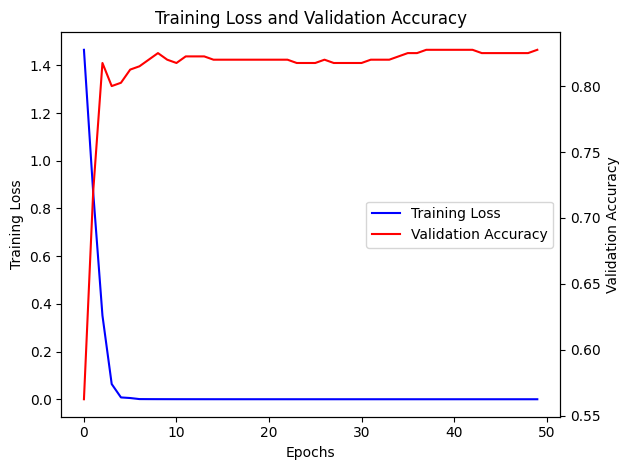

In [ ]:
# import matplotlib.pyplot as plt

# # Create the figure and axes
# fig, ax1 = plt.subplots()

# # Plot the training loss
# ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Training Loss')
# ax1.tick_params(axis='y')

# # Create a twin y-axis
# ax2 = ax1.twinx()

# # Plot the accuracy
# ax2.plot(epochs, eval_accs, 'r-', label='Validation Accuracy')
# ax2.set_ylabel('Validation Accuracy')
# ax2.tick_params(axis='y')

# # Add a legend
# lines = ax1.get_lines() + ax2.get_lines()
# ax1.legend(lines, [line.get_label() for line in lines], loc='center right')

# # Set the title and adjust layout
# plt.title('Training Loss and Validation Accuracy')
# fig.tight_layout()

# # Save the plot as a high-quality PDF file
# plt.savefig('results_plot.png')

In [ ]:
accuracy, predictions = test()
print(f'Accuracy: {accuracy}')

# If your data has ground truth labels, you can also use sklearn's classification_report for a detailed report.
print(classification_report(data['author'].y[data['author'].test_mask].cpu().numpy(), predictions.cpu().numpy()))

Accuracy: 0.8105618667485416
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       977
           1       0.70      0.75      0.72       584
           2       0.83      0.78      0.81       892
           3       0.81      0.84      0.82       804

    accuracy                           0.81      3257
   macro avg       0.80      0.80      0.80      3257
weighted avg       0.81      0.81      0.81      3257

